In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="darkgrid")

logdir = Path("/bigdata/cifar10/logs/decomposed")
import os
from datetime import datetime
from os.path import isdir

folders = os.listdir(logdir)
print(f"number of folders: {len(folders)}")
# from datetime import datetime

# dts = [datetime.fromtimestamp(int(x)) for x in folders]
# print(max(dts))
# print(min(dts))
from tddl.post_processing.path_utils import logdir_to_paths

paths = logdir_to_paths(logdir)

print(len(paths))
# baseline

baseline_path = Path("/bigdata/cifar10/logs/baselines/1646668631/rn18_18_dNone_128_adam_l0.001_g0.1_w0.0_sTrue")
# baseline_model = torch.load(baseline_path / "cnn_best.pth")
with open(baseline_path/'results.json') as json_file:
    baseline_result = json.load(json_file)
baseline_result
from tddl.post_processing.factorized_model import process_factorized_networks

# process_factorized_networks(paths, baseline_path)
from tddl.post_processing.path_utils import paths_to_df

df = paths_to_df(paths)
print(len(df))
df.head()

# df.groupby('rank').count()
# rank=0.90: 10 observations
# rank=0.75: 10 observstions

# Exclude the few observations (layer=28, decomp={cp,tucker}) where rank is 0.75 or 0.90

df = df[~df['rank'].isin(['0.75', '0.90'])]
df['test_error'] = 1 - df.test_acc
df['valid_error_before_ft'] = 1 - df.valid_acc_before_ft
df['valid_error'] = 1 - df.valid_acc

df['log_test_error'] = np.log(df.test_error)
df['log_valid_error_before_ft'] = np.log(df.valid_error_before_ft)
df['log_valid_error'] = np.log(df.valid_error)
df['rank'] = df['rank'].astype(float, copy=False)
# df['rank'].apply(float)
df['rank'].unique()
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df['fact_layers'] = df['factorization'] + '-' + df['layers'].apply(str)
df['layers_fact'] = df['layers'].apply(str) + '-' + df['factorization'] 
df.head()
df = df.astype({
    'layers':"category",
    'fact_layers':"category",
    'layers_fact':"category",
})

number of folders: 260
260
260


/home/jetzeschuurman/gitProjects/phd/tltorch/tltorch/factorized_tensors/core.py:145: UserWarning: Creating a subclass of FactorizedTensor TensorizedTensor with no name.
  warnings.warn(f'Creating a subclass of FactorizedTensor {cls.__name__} with no name.')


# Comparing different layers

In Figure 2 or 4 there are clusters of layers that seem to be separate from other layers. \
This resuls in seemingly different linear estimations of the relationship between approximation error and performance error. \
With the following we quantify the similarity / difference between layers.

## F-test for difference between layers

What I am currently doing is estimating an intercept $\alpha_{\ell}$ and a coefficient $\beta_\ell$ per layer $\ell$: 

$y_{i\ell} = \alpha_{\ell} + \beta_\ell * x_{i\ell} + \varepsilon_{i\ell}$

To measure the difference between layers, we estimate coefficients with respect to a specific layer, e.g. layer 15:

$y_i = \alpha_{15} + \beta_{15} * w_i + \sum_{\ell \in layers_{not15}} I_i * (\alpha_{\Delta \ell} + \beta_{\Delta\ell} * w_i) + \varepsilon_i $

where $I_i = 1$ if $i$ corresponds to layer $\ell$ and $I_i = 1$ if not.

Now layer $\ell$ can be compared to layer 15 by means of an F-test. 
The test can be used to test if $\alpha_{\Delta \ell}$ en $\beta_{\Delta \ell}$ are equal to zero. 
If this holds these two layers have a similar relationship.

This can be used to test for 15 vs 19, 15 vs 28, ..., 15 vs 64.


The estimated equation can then be based on 19:

$y_i = \alpha_{19} + \beta_{19} * w_i + \sum_{\ell \in layers_{not19}} I_i * (\alpha_{\Delta \ell} + \beta_{\Delta\ell} * w_i) + \varepsilon_i $

This can be used to test for 19 vs 28, ..., 19 vs 64.

The process can be repeated to fill the upper triangle of a matrix that thas rows and columns corresponding to the layers [19, 28, 38, 41, 44, 60, 63]. Element i,j show whether layer i and layer j have a similar or significantly different relationship.

In [3]:
import statsmodels.api as sm
import pandas as pd
from patsy import dmatrices
import numpy as np

In [4]:
df.columns

Index(['name', 'nr', 'relative_norm_weight', 'scaled_norm_weight',
       'diff_norm_weight', 'layers', 'factorization', 'rank', 'valid_acc',
       'valid_acc_before_ft', 'n_param_fact', 'test_acc', 'lr', 'optimizer',
       'norm_diff', 'norm_b', 'n_b', 'relative_norm', 'scaled_norm',
       'test_error', 'valid_error_before_ft', 'valid_error', 'log_test_error',
       'log_valid_error_before_ft', 'log_valid_error', 'fact_rank',
       'fact_layers', 'layers_fact'],
      dtype='object')

In [5]:
y, X = dmatrices('log_test_error ~ layers + layers:relative_norm_weight', data=df, return_type='dataframe')

In [6]:
X

,Intercept,layers[T.19],layers[T.28],layers[T.38],layers[T.41],layers[T.44],layers[T.60],layers[T.63],layers[15]:relative_norm_weight,layers[19]:relative_norm_weight,layers[28]:relative_norm_weight,layers[38]:relative_norm_weight,layers[41]:relative_norm_weight,layers[44]:relative_norm_weight,layers[60]:relative_norm_weight,layers[63]:relative_norm_weight
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.311843
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.337100,0.000000
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.272814,0.000000
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.823151,0.000000,0.0,0.000000,0.000000,0.000000
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.198279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.447319,0.000000,0.000000
256,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.160246
257,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.452808,0.0,0.000000,0.000000,0.000000
258,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.798234,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [7]:
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         log_test_error   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     66.14
Date:                Wed, 15 Jun 2022   Prob (F-statistic):           1.91e-73
Time:                        09:47:35   Log-Likelihood:                 657.61
No. Observations:                 240   AIC:                            -1283.
Df Residuals:                     224   BIC:                            -1228.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [8]:
R = [[
    0, 1, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 0, 0, 0, 0,
    ],[
    0, 0, 0, 0, 0, 0, 0, 0, 
    1, -1, 0, 0, 0, 0, 0, 0,
]]
res.f_test(R)


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=10.64941585426433, p=3.8184254634975756e-05, df_denom=224, df_num=2>

In [9]:

layers = [15,19,28,38,41,44,60,63]
p_values = np.zeros((len(layers), len(layers)))
# print(layers)
for i,l in enumerate(layers):
    for j,k in enumerate(layers[i+1:]):
        print(l,k)
        R = np.zeros((2,16))

        if i == 0:
            R[0,j+1] = 1 

        else:
            R[0,i] = 1
            R[0,j+i+1] = -1

        R[1,8+i] = 1
        R[1,8+j+i+1] = -1

        print(R)
        f = res.f_test(R)
        print(f)
        p_values[i+j,i] = f.pvalue

15 19
[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.]]
<F test: F=10.64941585426433, p=3.8184254634975756e-05, df_denom=224, df_num=2>
15 28
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.  0.  0.]]
<F test: F=78.7379286881748, p=1.269017414267539e-26, df_denom=224, df_num=2>
15 38
[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0. -1.  0.  0.  0.  0.]]
<F test: F=7.847615792708168, p=0.0005080727224531395, df_denom=224, df_num=2>
15 41
[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -1.  0.  0.  0.]]
<F test: F=16.179613873505225, p=2.733349286828302e-07, df_denom=224, df_num=2>
15 44
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0. 

In [10]:
p_values

array([[3.81842546e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.26901741e-26, 7.46801085e-10, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.08072722e-04, 9.47012122e-13, 2.23688861e-37, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.73334929e-07, 4.04514299e-18, 1.79501816e-51, 1.81560139e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.31668833e-07, 2.18108391e-16, 6.80520957e-41, 2.87719873e-01,
        5.91521452e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.14382133e-01, 7.37262977e-05, 2.56237296e-11, 5.73082790e-01,
        6.88107584e-04, 8.33796229e-01, 0.00000000e+00, 0.00000000e+00],
       [1.47013866e-01, 2.07025958e-05, 5.01427070e-12, 4.24403712e-01,
        5.22541212e-04, 7.71300241e-01, 8.65872026e-01, 0.

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

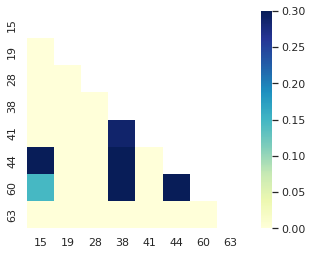

In [14]:
mask = np.zeros_like(p_values)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(pd.DataFrame(data=p_values,columns=layers, index=layers), mask=mask, vmax=.3, square=True,  cmap="YlGnBu")
    plt.savefig("../../plots/cifar10/rn18/f_test_similarity_layers")
    plt.show()


## Alternative: bootstrapping goodness of fit measure

Compute two linear equations, one based on all layers:

$y_{i} = \alpha + \beta * x_{i} + \varepsilon_{i}$

and the other on only the observations of layer $\ell$:

$y_{i\ell} = \alpha_{\ell} + \beta_\ell * x_{i\ell} + \varepsilon_{i\ell}$

Calculate the MSEs for observations of layer $\ell$ based on both equations.
Comparing the difference between the two MSEs gives an indication of how well layer $\ell$ can be described by fitting on all observations versus only layer $\ell$.

The limitation is that this is one layer versus the average.


### MSE
Average squared difference between predictions and true values

In [ ]:
$y_{i\ell} = \alpha_{\ell} + \beta_\ell * x_{i\ell} + \varepsilon_{i\ell}$

In [16]:
df.columns

Index(['name', 'nr', 'relative_norm_weight', 'scaled_norm_weight',
       'diff_norm_weight', 'layers', 'factorization', 'rank', 'valid_acc',
       'valid_acc_before_ft', 'n_param_fact', 'test_acc', 'lr', 'optimizer',
       'norm_diff', 'norm_b', 'n_b', 'relative_norm', 'scaled_norm',
       'test_error', 'valid_error_before_ft', 'valid_error', 'log_test_error',
       'log_valid_error_before_ft', 'log_valid_error', 'fact_rank',
       'fact_layers', 'layers_fact'],
      dtype='object')

In [17]:
y, X = dmatrices('log_test_error ~ factorization:layers + factorization:layers:relative_norm_weight', data=df, return_type='dataframe')

In [18]:
X

,Intercept,layers[T.19],layers[T.28],layers[T.38],layers[T.41],layers[T.44],layers[T.60],layers[T.63],factorization[T.tucker]:layers[15],factorization[T.tucker]:layers[19],...,factorization[cp]:layers[38]:relative_norm_weight,factorization[tucker]:layers[38]:relative_norm_weight,factorization[cp]:layers[41]:relative_norm_weight,factorization[tucker]:layers[41]:relative_norm_weight,factorization[cp]:layers[44]:relative_norm_weight,factorization[tucker]:layers[44]:relative_norm_weight,factorization[cp]:layers[60]:relative_norm_weight,factorization[tucker]:layers[60]:relative_norm_weight,factorization[cp]:layers[63]:relative_norm_weight,factorization[tucker]:layers[63]:relative_norm_weight
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.311843,0.000000
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.337100,0.000000,0.000000
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.272814,0.000000,0.000000
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.198279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.447319,0.0,0.000000,0.000000,0.000000
256,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.160246,0.000000
257,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.452808,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
258,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
